In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
import os
from torch.utils.data import Dataset, DataLoader
from SVarM_utils import *
from SVarM_models import Regression
from scipy.io import loadmat

Jupyter environment detected. Enabling Open3D WebVisualizer.
[Open3D INFO] WebRTC GUI backend enabled.
[Open3D INFO] WebRTCWindowSystem: HTTP handshake server disabled.


In [2]:
def rotation_matrix_z(theta):
    cos_theta = torch.cos(theta)
    sin_theta = torch.sin(theta)
    return torch.tensor([
        [cos_theta, -sin_theta, 0.0],
        [sin_theta,  cos_theta, 0.0],
        [0.0,        0.0,       1.0]
    ], dtype=torch.float32)    

In [3]:
class MeshDataset(Dataset):
    def __init__(self, IDs):
        self.IDs = IDs

    def __len__(self):
        return len(self.IDs)

    def __getitem__(self, idx):
        y,file_path = self.IDs[idx].split("+")
        file_path= file_path.strip()
        y=torch.tensor([float(y)])
        mesh = loadData(file_path)  
        R =  rotation_matrix_z(y)
        V1 = mesh[0]@R
        return [V1,mesh[1]], y

matdata = loadmat("data_splits/FAUST1D_data_splits.mat")
test_data = matdata['test_data'].tolist()
train_data = matdata['train_data'].tolist()
val_dataset = MeshDataset(test_data)
train_dataset = MeshDataset(train_data)

In [4]:
model = Regression()
sum(p.numel() for p in model.parameters() if p.requires_grad)

9651

In [5]:
batch_size =10
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, collate_fn=lambda x: list(zip(*x)))
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False, collate_fn=lambda x: list(zip(*x)))
criterion = criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=.005)
epochs = 100

In [6]:
for epoch in range(epochs):
    model.train()
    count = 0
    train_loss = 0.0
    for meshs, y in train_loader: 
        y = torch.stack(y)
        optimizer.zero_grad()
        outputs = model(meshs)
        loss = criterion(outputs,y)
        loss.backward()
        optimizer.step()
        count = count + 1
        train_loss += loss.item()
        
        print(f"Batch [{count}/{len(train_loader)}] - Train Loss: {loss.item():.4f}", end ="\r")

    train_loss /= len(train_loader)

    # Validation phase
    model.eval()
    val_loss = 0.0
    correct = 0
    total = 0

    with torch.no_grad():
        for meshs, y in val_loader:
            y = torch.stack(y)
            outputs = model(meshs)
            loss = criterion(outputs, y)
            val_loss += loss.item()

    val_loss /= len(val_loader)

    print(f"Epoch [{epoch+1}/{epochs}] - Train Loss: {train_loss:.4f}, Val Loss: {val_loss:.4f}")

Epoch [1/20] - Train Loss: 0.1696, Val Loss: 0.0513
Epoch [2/20] - Train Loss: 0.0500, Val Loss: 0.0353
Epoch [3/20] - Train Loss: 0.0369, Val Loss: 0.0246
Epoch [4/20] - Train Loss: 0.0258, Val Loss: 0.0202
Epoch [5/20] - Train Loss: 0.0212, Val Loss: 0.0165
Epoch [6/20] - Train Loss: 0.0193, Val Loss: 0.0203
Epoch [7/20] - Train Loss: 0.0161, Val Loss: 0.0161
Epoch [8/20] - Train Loss: 0.0141, Val Loss: 0.0117
Epoch [9/20] - Train Loss: 0.0118, Val Loss: 0.0132
Epoch [10/20] - Train Loss: 0.0090, Val Loss: 0.0072
Epoch [11/20] - Train Loss: 0.0067, Val Loss: 0.0075
Epoch [12/20] - Train Loss: 0.0053, Val Loss: 0.0100
Epoch [13/20] - Train Loss: 0.0037, Val Loss: 0.0022
Epoch [14/20] - Train Loss: 0.0033, Val Loss: 0.0016
Epoch [15/20] - Train Loss: 0.0028, Val Loss: 0.0141
Epoch [16/20] - Train Loss: 0.0029, Val Loss: 0.0008
Epoch [17/20] - Train Loss: 0.0024, Val Loss: 0.0013
Epoch [18/20] - Train Loss: 0.0021, Val Loss: 0.0015
Epoch [19/20] - Train Loss: 0.0019, Val Loss: 0.0016
Ep

In [7]:
torch.save(model.state_dict(), 'trained_models/FAUST_1D_rotation')

In [8]:
val_loader = DataLoader(val_dataset, batch_size=1, shuffle=False, collate_fn=lambda x: list(zip(*x)))
y_ls = []
outputs_ls = []
with torch.no_grad():
    for meshs, y in val_loader:
        y_ls += y
        outputs = model(meshs)
        outputs_ls += [outputs]
y = torch.stack(y_ls)
y_pred = torch.stack(outputs_ls)[:,0,0]

In [9]:
print((torch.abs(y_pred - y.detach().numpy())*360/6.28318530718).mean())
S = ((y_pred - y.detach().numpy())**2).mean()*(360/6.28318530718)**2
S2 = ((y.detach().numpy().mean() - y.detach().numpy())**2).mean()*(360/6.28318530718)**2
print(1 - S/S2)

tensor(61.3314)
tensor(-7.1952)


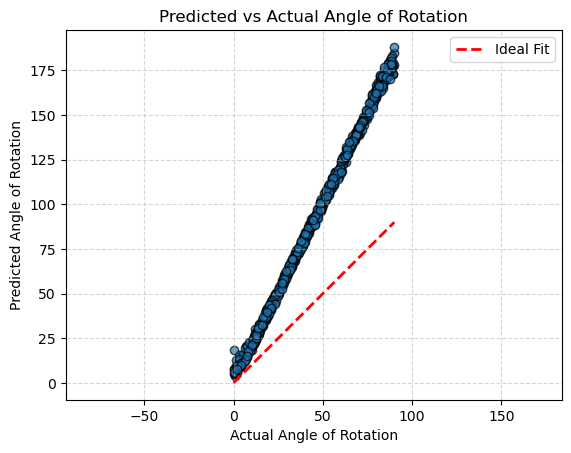

In [10]:
import matplotlib.pyplot as plt
y_true = y.detach().numpy()*360/6.28318530718
plt.scatter(y_true, y_pred*360/6.28318530718, alpha=0.7, edgecolor='k')
plt.plot([y_true.min(), y_true.max()],
         [y_true.min(), y_true.max()],
         'r--', lw=2, label='Ideal Fit')


plt.xlabel("Actual Angle of Rotation")
plt.ylabel("Predicted Angle of Rotation")
plt.title("Predicted vs Actual Angle of Rotation")
plt.legend()
plt.grid(True, linestyle='--', alpha=0.5)
plt.axis('equal')  # Ensure equal aspect ratio if ranges are similar
plt.savefig("Predicted vs Actual", dpi=800, bbox_inches='tight')
plt.show()